# Lorenz Attractor Chaos Readings #

In [1]:
# Library declaration
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import pi, cos, log
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits import mplot3d
import random

### Defining the lorenz equations ###

In [2]:
dx_dt = lambda sigma, x, y: -sigma*(x-y)
dy_dt = lambda r, x, y, z: x*(r - z) - y
dz_dt = lambda b, x, y, z: x*y - b*z

In [3]:
make_timestep = lambda v, dv_dt, timestep : v + (dv_dt * timestep)

In [36]:
@interact(sigma = (1,20,1), r = (1,100,1), b = (1/3,5,1/3), time = (1000, 50000, 1000), graph_select = (0,3,1))
def plot_curve(sigma, r, b, time, graph_select):
    plt.figure(figsize=(10,6))
    num = time
    x = np.zeros(num)
    y = np.zeros(num)
    z = np.zeros(num)
    x[0] = 1
    y[0] = 1
    z[0] = 1
    for i in range(num - 1):
        x[i+1] = make_timestep(x[i], dx_dt(sigma, x[i], y[i]), 0.01)
        y[i+1] = make_timestep(y[i], dy_dt(r, x[i], y[i], z[i]), 0.01)
        z[i+1] = make_timestep(z[i], dz_dt(b, x[i], y[i], z[i]), 0.01)
    if graph_select == 3:  
        ax = plt.axes(projection='3d')
        ax.plot3D(y, x, z, 'k-')
        plt.xlabel('x')
        plt.ylabel('y')
    else:
        ranges = [x, y, z]
        labels = ['k-', 'b-', 'r-']
        plt.plot(range(num), ranges[graph_select], labels[graph_select])
        plt.xlabel('time')
    plt.title('Lorenz attractor ' + str(['x','y','z','3D'][graph_select]) + '-data matched with time with sigma = '
              + str(sigma) + '; r = ' + str(r) + '; b = ' + str(round(b, 3)))
    plt.grid()
    plt.show()

interactive(children=(IntSlider(value=10, description='sigma', max=20, min=1), IntSlider(value=50, description…

In [5]:
def makeString(x):
    strin = ''
    decreasing = x[1] < x[0]
    increasing = x[1] > x[0]
    last_val = x[1]
    for i in range(len(x) - 2):
        j = i + 2
        if x[j] < 0 and decreasing and last_val < x[j]:
            strin += '0'
        elif x[j] > 0 and increasing and last_val > x[j]:
            strin += '1'
        
        decreasing = x[j] < last_val
        increasing = x[j] > last_val
        last_val = x[j]
    return strin

## Calculating Chaos

In [ ]:
num = 5000
sigma = 10
r = 50
b = 8/3
def createVariableSeries(num, sigma, r, b):
    x = np.zeros(num)
    y = np.zeros(num)
    z = np.zeros(num)
    x[0] = 1
    y[0] = 1
    z[0] = 1
    for i in range(num - 1):
        x[i+1] = make_timestep(x[i], dx_dt(sigma, x[i], y[i]), 0.01)
        y[i+1] = make_timestep(y[i], dy_dt(r, x[i], y[i], z[i]), 0.01)
        z[i+1] = make_timestep(z[i], dz_dt(b, x[i], y[i], z[i]), 0.01)
    return x
x = createVariableSeries(num, sigma, r, b)

In [7]:
makeString(x)

'10100010010010101001011101010010010111000111010100101000101000111000110101011010010101101101011010101101000'

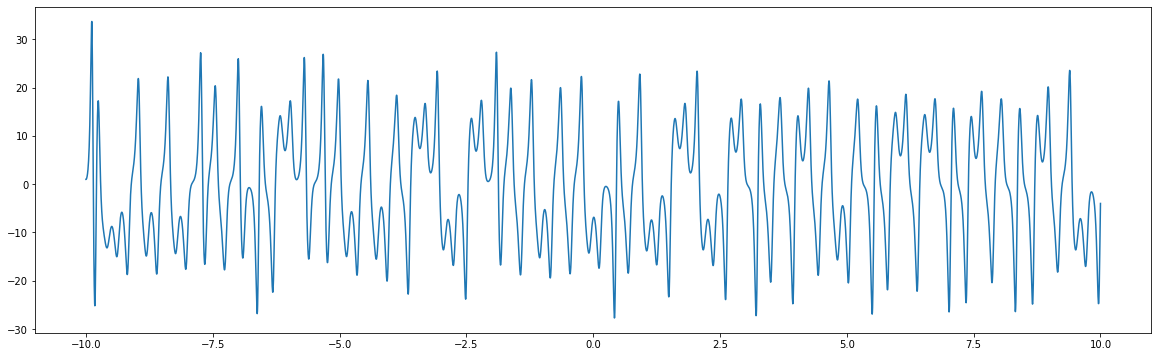

In [8]:
plt.figure(figsize=(20,6))
plt.plot(np.linspace(-10,10,num), x)

In [9]:
lstr = makeString(x)

### Information Entropy

In [10]:
def normalize(dist):
    sum = 0
    for i in range(len(dist)):
        sum += dist[i]
    if sum == 0:
        return []
    norm = [n / sum for n in dist]
    return norm
def findProbDist(bin, m):
    dist = [0] * int(pow(2,m))
    for i in range(len(bin)):
        if i + m > len(bin):
            return normalize(dist)
        if type(bin[1]) != int:
            sub = int(bin[i:i+m],2)
        else:
            sub = ""
            for j in range(i, i+m):
                sub += str(bin[j])
            sub = int(sub, 2)
        dist[sub] += 1
    return dist
def infEntrop(bin, m):
    if m == 0: return 0
    prob_dist = findProbDist(bin, m)
    sum = 0
    for i in range(len(bin)):
        if i + m > len(bin):
            return -1 * sum
        if type(bin[1]) != int:
            sub = int(bin[i:i+m],2)
        else:
            sub = ""
            for j in range(i, i+m):
                sub += str(bin[j])
            sub = int(sub, 2)
        sum += prob_dist[sub] * log(prob_dist[sub])
#     for i in prob_dist:
#         sum += i * log(i)
    return -1 * sum
def hm(bin, m):
    return (infEntrop(bin, m+1) / len(bin) - infEntrop(bin, m) / len(bin))

In [11]:
hm(lstr, 2)

-0.0655729216730947

In [12]:
prob = findProbDist(lstr, 3)

In [13]:
sum = 0
for i in prob:
    sum += i * log(i)
sum *= -1
sum

1.9254416884328187

### Markov Matrix and Lempel-Ziv(LZ) Complexity

In [14]:
def createMarkov(bin):
    markov = [[0,0],[0,0]]
    for i in range(len(bin)):
        if i + 1 == len(bin):
            break
        if type(bin[i]) != int:
            markov[1 - int(bin[i],2)][1 - int(bin[i+1],2)] += 1
        else:
            markov[1 - bin[i]][1 - bin[i+1]] += 1
    markov[0] = normalize(markov[0])
    markov[1] = normalize(markov[1])
    return markov

In [15]:
createMarkov("10100")

[[0.0, 1.0], [0.5, 0.5]]

In [16]:
def lempel_ziv_complexity(binary_sequence):
    u, v, w = 0, 1, 1
    v_max = 1
    length = len(binary_sequence)
    complexity = 1
    while True:
        if binary_sequence[u + v - 1] == binary_sequence[w + v - 1]:
            v += 1
            if w + v >= length:
                complexity += 1
                break
        else:
            if v > v_max:
                v_max = v
            u += 1
            if u == w:
                complexity += 1
                w += v_max
                if w > length:
                    break
                else:
                    u = 0
                    v = 1
                    v_max = 1
            else:
                v = 1
    return complexity

In [17]:
s = lempel_ziv_complexity(lstr)

In [18]:
s*log(len(lstr)) / len(lstr)

0.6987407602933691

In [19]:
r_range = np.arange(16, 64, 0.25)
s_ = {}
markov_ = {}
num = 20000
for r in r_range:
    x = createVariableSeries(num, sigma, r, b)
    lstr = makeString(x)
    s_[r] = lempel_ziv_complexity(lstr) * log(len(lstr)) / len(lstr)
    markov_[r] = createMarkov(lstr)

In [20]:
def makeArrayFromMarkov(markov, index1, index2):
    val = list(markov.values())
    a = [0]*len(val)
    for i in range(len(val)):
        a[i] = val[i][index1][index2]
    return a

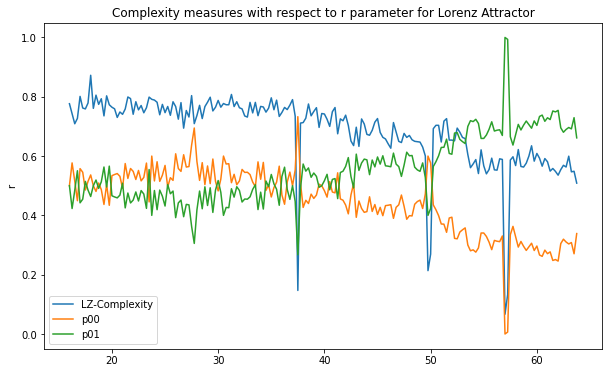

In [21]:
plt.figure(figsize=(10,6))
plt.plot(r_range, s_.values())
plt.plot(r_range, makeArrayFromMarkov(markov_, 1, 1))
plt.plot(r_range, makeArrayFromMarkov(markov_, 1, 0))
plt.legend(["LZ-Complexity", "p00", "p01"])
plt.ylabel("r")
plt.title("Complexity measures with respect to r parameter for Lorenz Attractor")
plt.show()

In [22]:
markov_

{16.0: [[0.5865384615384616, 0.41346153846153844], [0.5, 0.5]],
 16.25: [[0.4883720930232558, 0.5116279069767442],
  [0.4230769230769231, 0.5769230769230769]],
 16.5: [[0.5154639175257731, 0.4845360824742268],
  [0.4842105263157895, 0.5157894736842106]],
 16.75: [[0.5283018867924528, 0.4716981132075472],
  [0.550561797752809, 0.449438202247191]],
 17.0: [[0.4946236559139785, 0.5053763440860215],
  [0.4423076923076923, 0.5576923076923077]],
 17.25: [[0.5588235294117647, 0.4411764705882353],
  [0.45454545454545453, 0.5454545454545454]],
 17.5: [[0.45454545454545453, 0.5454545454545454],
  [0.5145631067961165, 0.4854368932038835]],
 17.75: [[0.5242718446601942, 0.47572815533980584],
  [0.48514851485148514, 0.5148514851485149]],
 18.0: [[0.4639175257731959, 0.5360824742268041],
  [0.4636363636363636, 0.5363636363636364]],
 18.25: [[0.5, 0.5], [0.5, 0.5]],
 18.5: [[0.49074074074074076, 0.5092592592592593],
  [0.5192307692307693, 0.4807692307692308]],
 18.75: [[0.4807692307692308, 0.51923076

# Analyzing Randomness with same methodology

In [23]:
def randomness(n):
    r = [0] * n
    for i in range(n):
        r[i] = random.randint(1,100) % 2
    return r

In [24]:
rand_ = {}
rand_lz = {}
rand_markov = {}

In [25]:
for r in r_range:
    rand_[r] = randomness(len(lstr))
    rand_lz[r] = lempel_ziv_complexity(rand_[r]) * log(len(rand_[r])) / len(rand_[r])
    rand_markov[r] = createMarkov(rand_[r])

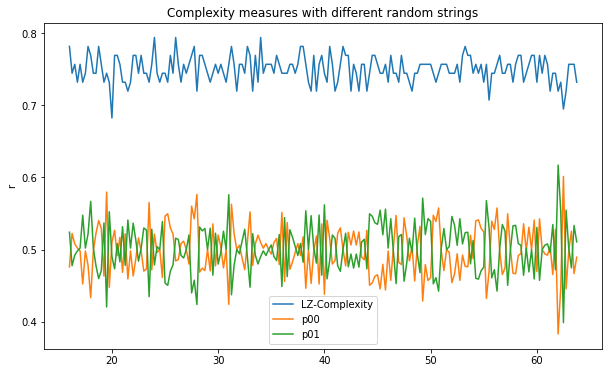

In [26]:
plt.figure(figsize=(10,6))
plt.plot(r_range, rand_lz.values())
plt.plot(r_range, makeArrayFromMarkov(rand_markov, 1, 1))
plt.plot(r_range, makeArrayFromMarkov(rand_markov, 1, 0))
plt.legend(["LZ-Complexity", "p00", "p01"])
plt.ylabel("r")
plt.title("Complexity measures with different random strings")
plt.show()

In [27]:
infEntrop(rand_[16], 3) - infEntrop(lstr, 3)

-17.602573938805904

In [28]:
r_entrop = {}
l_entrop = {}
for i in range(3,11):
    r_entrop[i] = infEntrop(rand_[16], i)
    l_entrop[i] = infEntrop(lstr, i)

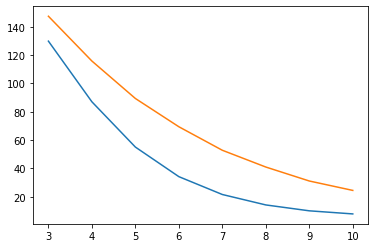

In [29]:
plt.plot(range(3,11), r_entrop.values())
plt.plot(range(3,11), l_entrop.values())

# Comparing complexity of chaotic vs before stability systems

In [30]:
r = 50
x_={}
for num in np.arange(start=1000, stop=20000, step=1000):
    x_[num] = createVariableSeries(num, sigma, r, b)

KeyboardInterrupt: 

In [ ]:
r = 29
x_c={}
for num in np.arange(start=1000, stop=20000, step=1000):
    x_c[num] = createVariableSeries(num, sigma, r, b)

In [ ]:
num_range = np.arange(start=1000, stop=20000, step=1000)

In [ ]:
s_ = {}
markov_ = {}
for num in num_range:
    lstr = makeString(x_[num])
    s_[num] = lempel_ziv_complexity(lstr) * log(len(lstr)) / len(lstr)
    markov_[num] = createMarkov(lstr)
s_c = {}
markov_c = {}
for num in num_range:
    lstr = makeString(x_c[num])
    s_c[num] = lempel_ziv_complexity(lstr) * log(len(lstr)) / len(lstr)
    markov_c[num] = createMarkov(lstr)

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(num_range, s_.values())
plt.plot(num_range, makeArrayFromMarkov(markov_, 1, 1))
plt.plot(num_range, makeArrayFromMarkov(markov_, 1, 0))
plt.legend(["LZ-Complexity", "p00", "p01"])
plt.ylabel("num")
plt.tick_params(labelbottom=False)
plt.text(9500,0.7,"r=50: Stable at around num=5000")
plt.suptitle("Complexity measures with respect to length of duration for Lorenz Attractor")
plt.subplot(2,1,2)
plt.plot(num_range, s_c.values())
plt.plot(num_range, makeArrayFromMarkov(markov_c, 1, 1))
plt.plot(num_range, makeArrayFromMarkov(markov_c, 1, 0))
plt.legend(["LZ-Complexity", "p00", "p01"])
plt.ylabel("num")
plt.text(10000,0.7,"r=29: Continual Chaos")
plt.show()